In [3]:
%cd ../../
import pandas as pd
import os
import json
from orderbookrl.evaluate.hp_utils import get_data, get_dataframe
import seaborn as sns
import statsmodels.api as sm
from statsmodels.formula.api import ols
import matplotlib.pyplot as plt
from sklearn import tree
import graphviz 
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

/media/olle/DATA/Projects/orderbookrl


In [4]:
logs_dir = 'logs/marketorderenvnofee/ppo-cr-opt-hp/'
cols = ['cap_mean', 'timesteps_this_iter']
data_dict = get_data(logs_dir, cols)

hpcols = set(['gamma', 'lr', 'clip_param', 'entropy_coeff'])
temp = get_dataframe(data_dict, hpcols)

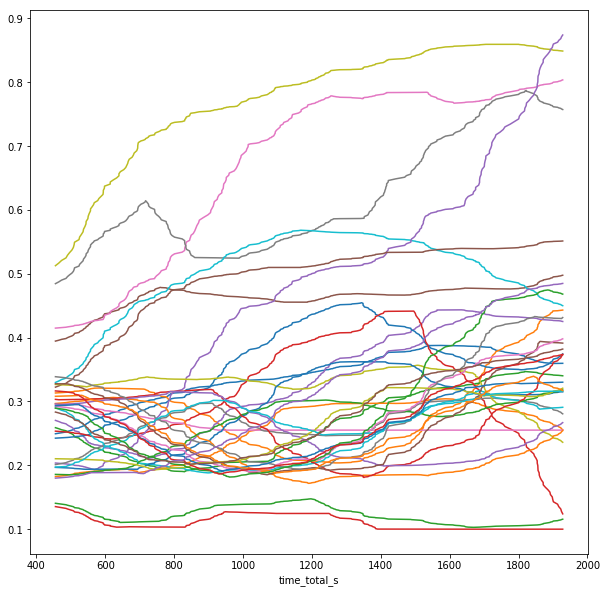

In [5]:
temp = temp.ffill().bfill()
temp.rolling(100).mean().dropna().plot(figsize=(10,10), legend=False); # .legend(bbox_to_anchor=(1.1, 1));

In [8]:
x = temp[1900:].mean()
x.sort_values(ascending=False).head(n=30).to_frame()

0
clip_param entropy_coeff gamma lr             
0.05       1e-06         0.99  0.1    0.974796
                               0.01   0.846713
           0.0001        0.999 0.01   0.788011
0.2        1e-06         0.99  0.01   0.752002
0.05       1e-06         0.999 0.01   0.537515
0.2        0             0.999 0.1    0.526404
0.05       0             0.99  0.01   0.506035
                         0.999 0.1    0.482777
0.2        0             0.99  0.01   0.450372
0.05       0.0001        0.99  0.001  0.441690
                         0.999 0.001  0.437037
0.2        0.0001        0.999 0.01   0.424833
                         0.99  0.01   0.422220
0.05       1e-06         0.999 0.1    0.412596
           0             0.99  0.001  0.403194
0.2        0.0001        0.99  0.001  0.403160
0.05       0             0.999 0.01   0.393040
0.2        1e-06         0.999 0.01   0.380625
           0             0.999 0.01   0.375800
                               0.001  0.349485
0.05       0             0.999 0.001  0.343403
0.2        0.0001        0.999 0.001  0.342674
0.05       0             0.99  0.1    0.339899
           1e-06         0.99  0.001  0.326459
0.2        1e-06         0.999 0.001  0.325306
                         0.99  0.001  0.316583
0.05       1e-06         0.999 0.001  0.315842
           0.0001        0.99  0.01   0.297337
0.2        0             0.99  0.1    0.255129
                               0.001  0.235895

In [9]:
x.sort_values(ascending=False).tail(n=10).to_frame()

0
clip_param entropy_coeff gamma lr             
0.05       1e-06         0.999 0.001  0.315842
           0.0001        0.99  0.01   0.297337
0.2        0             0.99  0.1    0.255129
                               0.001  0.235895
0.05       0.0001        0.99  0.1    0.221795
0.2        0.0001        0.999 0.1    0.190429
                         0.99  0.1    0.184345
0.05       0.0001        0.999 0.1    0.159640
0.2        1e-06         0.99  0.1    0.099966
                         0.999 0.1    0.099926

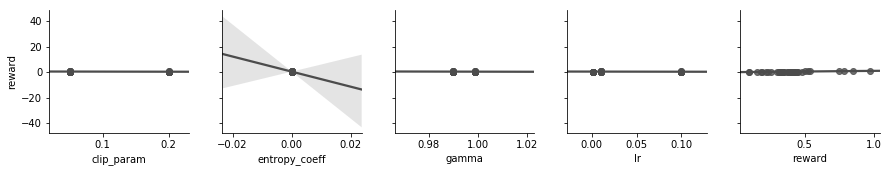

In [10]:
data = x.to_frame(name='reward').reset_index().astype(float)
data = data.rename(columns={'lambda':'lamb'})
cols = [str(c) for c in data.columns]

g = sns.PairGrid(data, x_vars=cols, y_vars='reward')
g.map(sns.regplot, color=".3");

In [15]:
' + '.join(cols)

'clip_param + entropy_coeff + gamma + lr + reward'

In [16]:
data_mean = data.subtract(data.mean()) / data.std()
model = ols(formula='reward ~ ' + '  + '.join(cols),
             data=data_mean).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 reward   R-squared:                       1.000
Model:                            OLS   Adj. R-squared:                  1.000
Method:                 Least Squares   F-statistic:                 2.508e+31
Date:                Mon, 17 Sep 2018   Prob (F-statistic):               0.00
Time:                        19:34:24   Log-Likelihood:                 1218.6
No. Observations:                  36   AIC:                            -2425.
Df Residuals:                      30   BIC:                            -2416.
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
Intercept      2.776e-17   8.81e-17      0.315      0.755   -1.52e-16    2.08e-16
clip_param    -1.388e-17   9.37e-17     -0.148      0.883   -2.05e-16    1.78e-16
entropy_coeff -4.684e-17   8.99e-17     -0.521      0.606    -2.3e-16    1.37e-16
gamma          4.372e-16   8.99e-17      4.864      0.000    2.54e-16    6.21e-16
lr             2.776e-17   9.18e-17      0.302      0.764    -1.6e-16    2.15e-16
reward            1.0000   9.72e-17   1.03e+16      0.000       1.000       1.000
==============================================================================
Omnibus:                       13.012   Durbin-Watson:                   1.336
Prob(Omnibus):                  0.001   Jarque-Bera (JB):                2.799
Skew:                           0.064   Prob(JB):                        0.247
Kurtosis:                       1.640   Cond. No.                         1.52
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

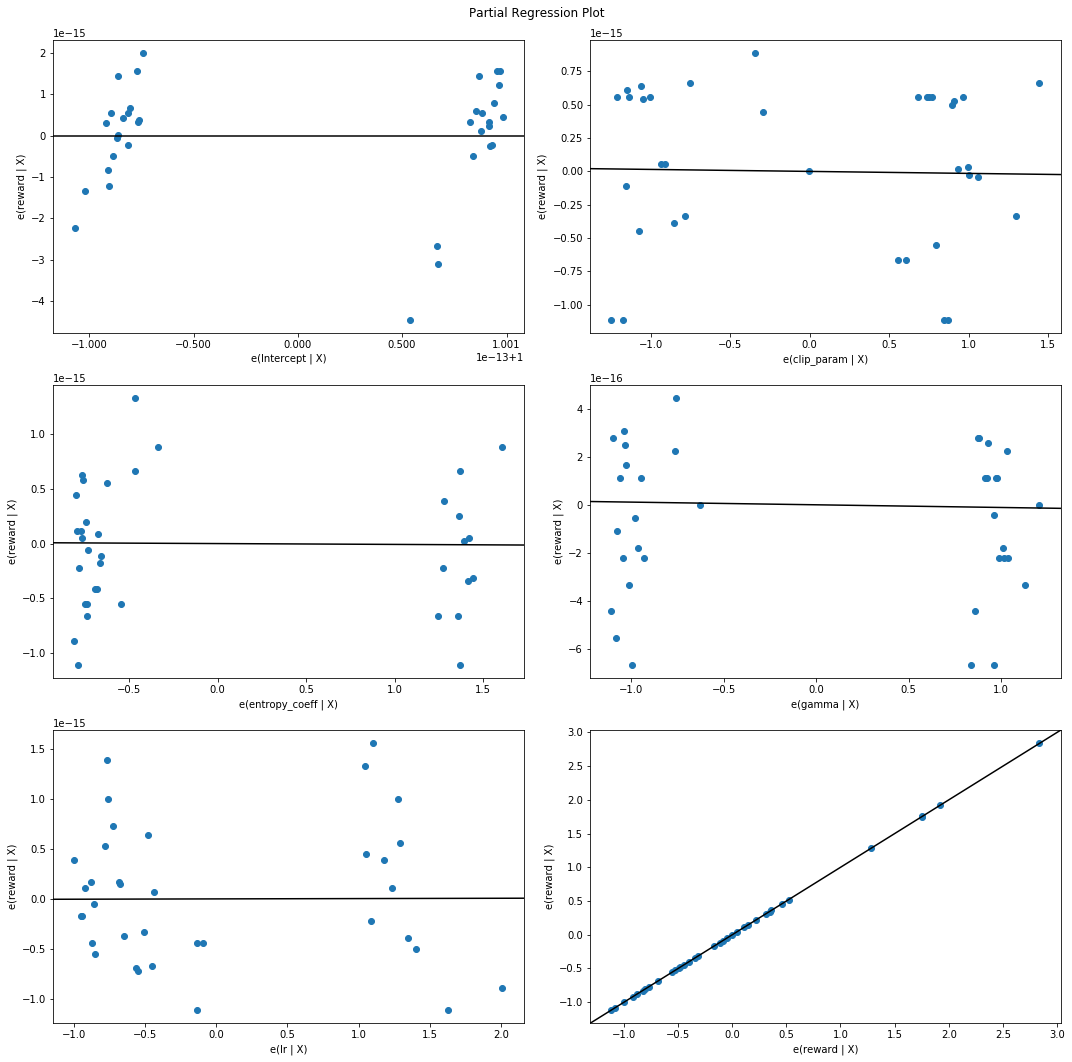

In [17]:
fig = plt.figure(figsize=(15,15))
sm.graphics.plot_partregress_grid(model, fig=fig);

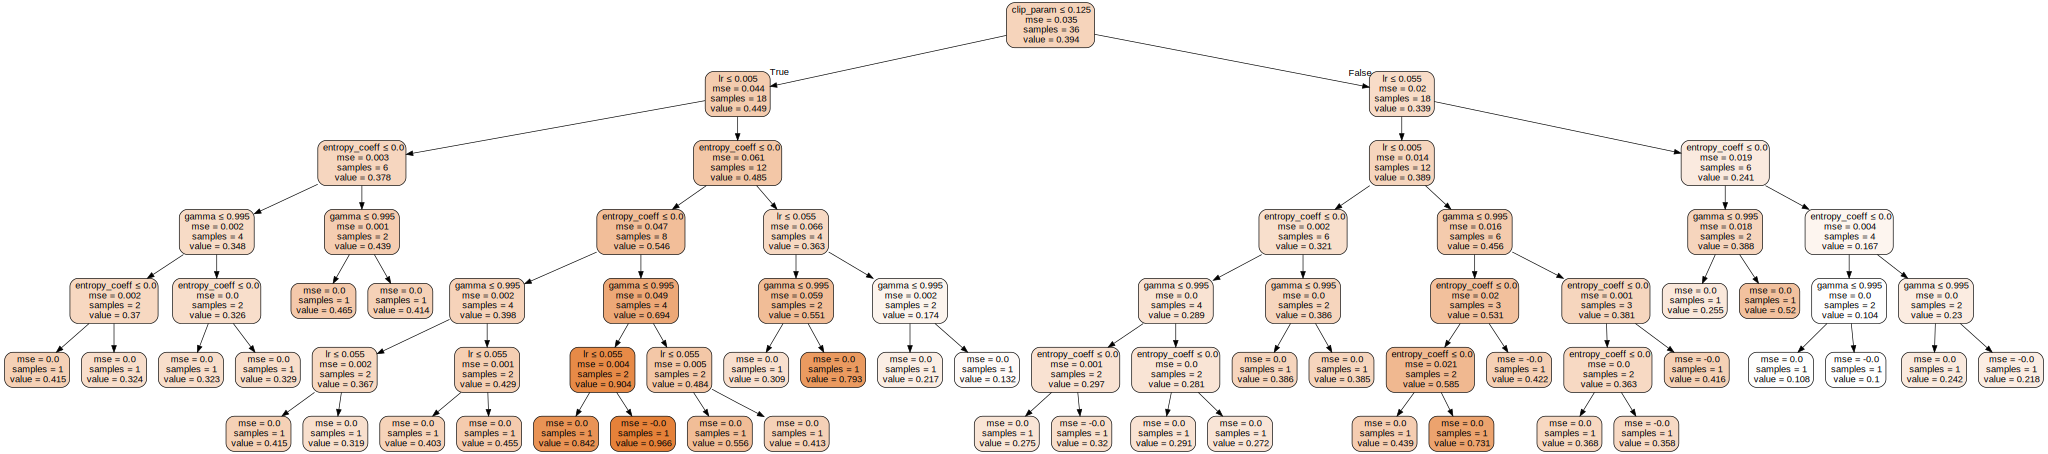

In [18]:
cols = list(data.columns.values)
cols.remove('reward')
reg = tree.DecisionTreeRegressor().fit(data[cols], data['reward'])
dot_data = tree.export_graphviz(reg, out_file=None,
                         feature_names=cols,   
                         filled=True, rounded=True,  
                         special_characters=True)  
graphviz.Source(dot_data)  